###需要先clone https://github.com/jlko/semantic_uncertainty 用于计算语义熵，以及token_log_likelihood_dic

## 
需要先clone https://github.com/jlko/semantic_uncertainty 用于计算语义熵，以及token_log_likelihood_dic
def get_token_log_likelihoods_dic(self, input_sentence):
    # 使用tokenizer获取输入和偏移映射
    inputs = self.tokenizer(input_sentence, return_tensors="pt")
    tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # 获取每个token的字符串表示
    inputs = inputs.to("cuda")
    
    # 计算模型的输出
    with torch.no_grad():
        outputs = self.model(**inputs)

    # 获取 logits
    logits = outputs.logits

    # 计算每个 token 的 log likelihoods
    log_likelihoods = []
    for i, token in enumerate(tokens):
        token_id = inputs['input_ids'][0, i].item()
        
        # 对当前位置的logits应用softmax得到概率分布，然后取log
        token_probs = F.log_softmax(logits[0, i], dim=-1)
        
        # 获取指定token的log likelihood
        log_prob = token_probs[token_id].item()
        
        # 替换<s>和</s>为[BOS]和[EOS]
        if token == '<s>':
            token = '[BOS]'
        elif token == '</s>':
            token = '[EOS]'
        
        log_likelihoods.append((token, log_prob))  # 将token和log likelihood配对

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.notebook import tqdm
import math
from collections import Counter
import re
import spacy

from transformers import AutoTokenizer, AutoModel
import os
from sentence_transformers.util import cos_sim

os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

import sys
sys.path.append("/home/liujunhui/workspace/proj/semantic_uncertainty/semantic_uncertainty")

import argparse
from uncertainty.utils import utils
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy

In [2]:
# 定义参数
args = argparse.Namespace(
    dataset="trivia_qa",
    model_name="Llama-2-7b-chat-8bit",
    model_max_new_tokens=512,
    debug=False,
    entity=None,
    random_seed=10,
    metric='squad',
    compute_accuracy_at_all_temps=True,
    experiment_lot='Unnamed Experiment',
    recompute_accuracy=False,
    train_wandb_runid=None,
    num_eval_samples=10000000000000000000,
    compute_predictive_entropy=True,
    compute_p_ik=True,
    compute_p_ik_answerable=False,
    compute_context_entails_response=False,
    analyze_run=True,
    assign_new_wandb_id=False,
    restore_entity_eval=None,
    restore_entity_train=None,
    condition_on_question=True,
    strict_entailment=True,
    use_all_generations=True,
    use_num_generations=-1,
    entailment_model='deberta',
    entailment_cache_id=None,
    entailment_cache_only=False,
    compute_p_true_in_compute_stage=False,
    reuse_entailment_model=False,
    use_mc_options=False
)

In [3]:
# Initialize model.
model = utils.init_model(args)
# Temperature for first generation is always `0.1`.
temperature = 0.1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# 香农熵
def calculate_entropy(sentence):
    # 使用正则表达式分割，匹配空格和换行符
    words = re.findall(r'\w+|\s|\n|\t', sentence.lower())
    
    # 计算每个单词的频率
    word_counts = Counter(words)
    # print(word_counts)
    total_words = len(words)
    
    # 计算香农熵
    entropy = 0.0
    for count in word_counts.values():
        p = count / total_words
        entropy -= p * math.log2(p)
    
    return entropy

# 困惑度
def calculate_perplexity(sentence):
    entropy = calculate_entropy(sentence)
    perplexity = 2 ** entropy
    return perplexity

# fluency
tokenizer_fluency = AutoTokenizer.from_pretrained("/home/liujunhui/workspace/models/parrot_fluency_model")
model_fluency = AutoModelForSequenceClassification.from_pretrained("/home/liujunhui/workspace/models/parrot_fluency_model")

# toxicity
tokenizer_toxicity = AutoTokenizer.from_pretrained("/home/liujunhui/workspace/models/roberta_toxicity_classifier")
model_toxicity = AutoModelForSequenceClassification.from_pretrained("/home/liujunhui/workspace/models/roberta_toxicity_classifier")

# semantic_similarity
#  device_map='auto'
model_semantic_similarity = AutoModel.from_pretrained('/home/css/models/NV-Embed-v2', trust_remote_code=True, device_map='auto')

def analyze_fluency(sentence):

    inputs = tokenizer_fluency(sentence, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad():
        outputs = model_fluency(**inputs)
    
    logits = outputs.logits
    fluency_score = torch.softmax(logits, dim=1)[0][1].item()

    return fluency_score

def analyze_toxicity(sentence):

    inputs = tokenizer_toxicity(sentence, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad():
        outputs = model_toxicity(**inputs)
    
    logits = outputs.logits
    toxicity_score = torch.softmax(logits, dim=1)[0][1].item()

    return toxicity_score


def calculate_semantic_similarity(sentence1, sentence2, max_length=32768):

    embeddings = model_semantic_similarity.encode([sentence1, sentence2], 
                                                  instruction="Retrieve semantically similar text.", 
                                                  max_length=max_length)
    
    similarity = cos_sim(embeddings[0], embeddings[1])
    
    return similarity.item()

Some weights of the model checkpoint at /home/liujunhui/workspace/models/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


## 导入数据集

In [5]:
# original文本文件路径
file_path_1 = "../dataset/jfleg_txt/jfleg/sources.txt"
file_path_2 = "../dataset/jfleg_txt/jfleg/corrections.txt"
# 打开文件并读取内容到列表
with open(file_path_1, "r") as file:
    jfleg_lst = [line.strip() for line in file.readlines()]

with open(file_path_2, "r") as file:
    jfleg_lst.extend([line.strip() for line in file.readlines()])

file_path_3 = "../dataset/jfleg_txt/jfleg_corrected/sources.txt"
file_path_4 = "../dataset/jfleg_txt/jfleg_corrected/corrections.txt"

# 打开文件并读取内容到列表
with open(file_path_3, "r") as file:
    jfleg_lst_wsc = [line.strip() for line in file.readlines()]

with open(file_path_4, "r") as file:
    jfleg_lst_wsc.extend([line.strip() for line in file.readlines()])

In [6]:
print(len(jfleg_lst))
print(len(jfleg_lst_wsc))

3202
3202


## 生成评估指标excel

In [7]:
flu_lst=[]
tox_lst=[]
entropy_lst=[]
ppl_lst=[]
ss_lst=[]
semantic_entropy_lst=[]

for i in tqdm(range(len(jfleg_lst))):

    ori_text = jfleg_lst[i]
    cor_text = jfleg_lst_wsc[i]

    flu_lst.append(analyze_fluency(cor_text)-analyze_fluency(ori_text))
    tox_lst.append(analyze_toxicity(cor_text)-analyze_toxicity(ori_text))
    entropy_lst.append(calculate_entropy(cor_text)-calculate_entropy(ori_text))
    ppl_lst.append(calculate_perplexity(cor_text)-calculate_perplexity(ori_text))
    ss_lst.append(calculate_semantic_similarity(ori_text,cor_text))
    semantic_entropy_lst.append(predictive_entropy(model.get_token_log_likelihoods(cor_text)) -
                                 predictive_entropy(model.get_token_log_likelihoods(ori_text)))

# 创建一个包含这四个列表的字典
data = {
    'ori_text':jfleg_lst,
    'cor_text':jfleg_lst_wsc,
    'fluency': flu_lst,
    'toxicity': tox_lst,
    'Shannon entropy':entropy_lst,
    'perplexity': ppl_lst,
    'semantic entropy':semantic_entropy_lst,
    'semantic similarity':ss_lst
}

# 将字典转换为DataFrame
df = pd.DataFrame(data)

  0%|          | 0/3202 [00:00<?, ?it/s]

/home/liujunhui/.cache/huggingface/modules/transformers_modules/NV-Embed-v2/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/liujunhui/miniconda3/envs/semantic_uncertainty/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [8]:
df.head()

,ori_text,cor_text,fluency,toxicity,Shannon entropy,perplexity,semantic entropy,semantic similarity
0,So I think we would not be live if our ancesto...,So I think we would not belive if our ancestor...,0.302740,5.091497e-07,0.014341,0.079090,0.540797,0.901009
1,Imagine yourself you are working in factory ju...,Imagine yourself you are working in factory ju...,-0.004786,-4.645365e-04,0.062624,0.463773,0.044193,0.992025
2,"For example , they can play football whenever ...","For example, they can play football whenever t...",0.002559,-8.590570e-06,0.202850,0.941190,0.668214,0.963557
3,While It is true that consumers preffer to buy...,While It is true that consumers preffer to buy...,0.000000,4.936774e-07,0.083739,0.691510,0.138582,0.994655
4,And young people spend more time on ther lifes...,And young people spend more time on ther lifes...,0.000000,4.362009e-07,0.090736,0.389478,0.167218,0.991845


In [9]:
# 保存DataFrame到Excel文件
excel_file_path = 'jfleg_data_all.xlsx'  # 输出的Excel文件路径
df.to_excel(excel_file_path, index=False)

In [ ]:
# df = pd.read_excel("jfleg_data_all.xlsx")
# df = df.rename(columns={'shannon_entropy': 'Shannon entropy','semantic_similarity':'semantic similarity','semantic_entropy':'semantic entropy'})
# excel_file_path = 'jfleg_data_all.xlsx'  # 输出的Excel文件路径
# df.to_excel(excel_file_path, index=False)

## 可视化

### 图1

In [10]:
# overcorrection case study
text_1="This will reduce the pollution caused by the carbones from the cars ."
text_2="This will reduce the pollution caused by the car bones from the cars."

ori_dic=model.get_token_log_likelihoods_dic(text_1)
cor_dic=model.get_token_log_likelihoods_dic(text_2)
print(model.get_token_log_likelihoods_dic(text_1))
print(model.get_token_log_likelihoods_dic(text_2))

[('[BOS]', -11.237125396728516), ('▁This', -11.858711242675781), ('▁will', -10.11039924621582), ('▁reduce', -12.407003402709961), ('▁the', -8.879886627197266), ('▁poll', -12.396705627441406), ('ution', -13.708147048950195), ('▁caused', -11.314926147460938), ('▁by', -10.547585487365723), ('▁the', -9.66524887084961), ('▁car', -11.1733980178833), ('b', -18.31064224243164), ('ones', -13.203455924987793), ('▁from', -10.53235912322998), ('▁the', -8.116357803344727), ('▁cars', -9.48948860168457), ('▁.', -6.343552589416504), ('[EOS]', -4.968552589416504)]
[('[BOS]', -11.227346420288086), ('▁This', -11.81181812286377), ('▁will', -10.044952392578125), ('▁reduce', -12.417708396911621), ('▁the', -8.851263999938965), ('▁poll', -12.475783348083496), ('ution', -13.632890701293945), ('▁caused', -11.289347648620605), ('▁by', -10.46395492553711), ('▁the', -9.693716049194336), ('▁car', -11.415257453918457), ('▁b', -9.925092697143555), ('ones', -13.010881423950195), ('▁from', -9.179254531860352), ('▁the',

In [12]:
ori_dic=[('[BOS]', -11.237125396728516), ('▁This', -11.858711242675781), ('▁will', -10.11039924621582), ('▁reduce', -12.407003402709961), ('▁the', -8.879886627197266), ('▁poll', -12.396705627441406), ('ution', -13.708147048950195), ('▁caused', -11.314926147460938), ('▁by', -10.547585487365723), ('▁the', -9.66524887084961), ('▁car', -11.1733980178833), ('b', -18.31064224243164), ('ones', -13.203455924987793), ('▁from', -10.53235912322998), ('▁the', -8.116357803344727), ('▁cars', -9.48948860168457), ('▁.', -6.343552589416504), ('[EOS]', -4.968552589416504)]
cor_dic=[('[BOS]', -11.227346420288086), ('▁This', -11.81181812286377), ('▁will', -10.044952392578125), ('▁reduce', -12.417708396911621), ('▁the', -8.851263999938965), ('▁poll', -12.475783348083496), ('ution', -13.632890701293945), ('▁caused', -11.289347648620605), ('▁by', -10.46395492553711), ('▁the', -9.693716049194336), ('▁car', -11.415257453918457), ('▁b', -9.925092697143555), ('ones', -13.010881423950195), ('▁from', -9.179254531860352), ('▁the', -8.306880950927734), ('▁cars', -8.226369857788086), ('.', -8.616849899291992), ('[EOS]', -5.246244430541992)]

In [13]:
data = []
text = []

# 处理 ori_dic
temp_1 = []
temp_2 = []
for item in ori_dic:
    temp_1.append(item[1])
    temp_2.append(item[0])

data.append(temp_1)
text.append(temp_2)

# 处理 cor_dic
temp_1 = []  # 重新定义 temp_1 为新的空列表
temp_2 = []  # 重新定义 temp_2 为新的空列表
for item in cor_dic:
    temp_1.append(item[1])
    temp_2.append(item[0])

data.append(temp_1)
text.append(temp_2)

Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Times New Roman.
Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Times New Roman.
Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Times New Roman.


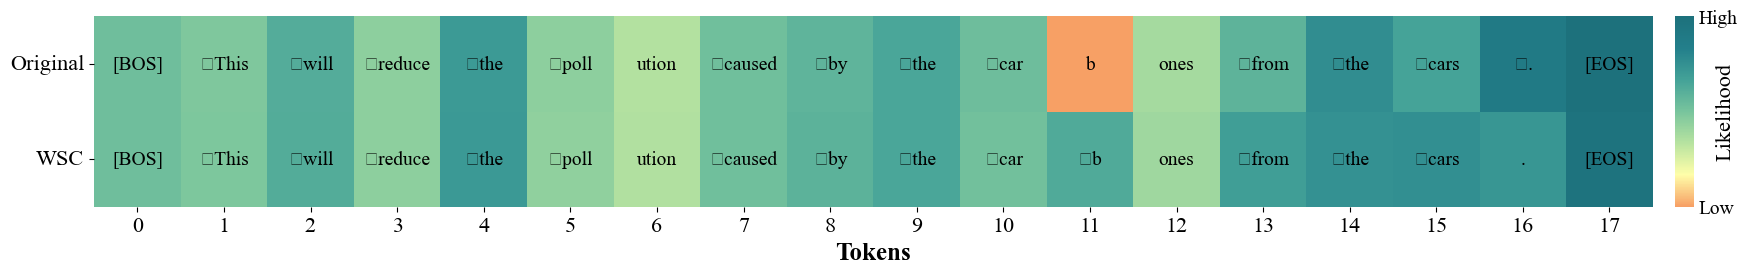

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Times New Roman'
font = {'family': 'serif',
        'weight': "medium"
        }

clist = ["#F7A065", "#fffea9", "#b7e3a0", "#78c49d", "#44a298","#237f8b","#1D717C"]
newcmp = LinearSegmentedColormap.from_list('chaos', clist)
# 将列表 data 转换为 NumPy 数组
data_array = np.array(data)

# 创建画布
fig, ax = plt.subplots(figsize=(24, 4 * 0.618))
# ax.set_aspect(0.5)
# 使用 seaborn 绘制热力图
cax = sns.heatmap(
    data_array,
    ax=ax,
    cmap=newcmp,
    annot=False,       # 显示每个格子的值
    cbar_kws={"pad": 0.012, "shrink": 1, "aspect": 10}  # 颜色条的大小
)

# 设置颜色条
cbar = cax.collections[0].colorbar
vmin, vmax = data_array.min(), data_array.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14, size=0)
cbar.set_label("Likelihood", labelpad=-16, size=16)

# 在格子中添加文本
for i in range(data_array.shape[0]):
    tokens = text[0] if i == 0 else text[1]
    for j in range(data_array.shape[1]):
        ax.text(j + 0.5, i + 0.5, tokens[j], ha="center", va="center", color="black", fontsize=14)

# 设置坐标轴标签
ax.set_xlabel('Tokens', fontsize=18, fontdict={'weight': 'bold'})

ax.tick_params(axis='x', labelsize=16)

# 设置 y 轴刻度和标签
row_labels = ['Original', 'WSC']
ax.set_yticks(np.arange(len(row_labels)) + 0.5)  # 设置y轴的刻度位置
ax.set_yticklabels(row_labels, fontsize=16, rotation=0)  # y轴标签并旋转为水平


plt.savefig('./plot_1_300dpi.jpg', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_1_300dpi.png', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_1_300dpi.tiff', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_1_300dpi.svg', bbox_inches='tight', dpi=300)
plt.show()

### 图2

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
from seaborn import colors
import shap
import matplotlib.ticker as mticker
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
cols = [2, 3, 4, 5, 6, 7]
cols_name = ['semantic similarity', 'fluency', 'toxicity', 'Shannon entropy', 'perplexity','semantic entropy']
df = pd.read_excel("jfleg_data_all.xlsx", usecols=cols)

# 提取 'semantic_similarity' 列
semantic_similarity = df[['semantic similarity']]

# 对其他列进行标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns=['semantic similarity']))
df_scaled = pd.DataFrame(scaled_data, columns=df.columns[:-1])  # 除去 'semantic_similarity' 后的列名

# 将 'semantic_similarity' 列合并回去
df_scaled = pd.concat([semantic_similarity.reset_index(drop=True), df_scaled], axis=1)

# 选择所需列
data = df_scaled[cols_name]
data.head()


,semantic similarity,fluency,toxicity,Shannon entropy,perplexity,semantic entropy
0,0.901009,0.598343,0.016714,0.723976,0.373239,0.665820
1,0.992025,0.342702,0.014098,0.758437,0.506295,0.510259
2,0.963557,0.348808,0.016663,0.858522,0.671426,0.705733
3,0.994655,0.346681,0.016714,0.773507,0.585065,0.539826
4,0.991845,0.346681,0.016714,0.778501,0.480598,0.548796


[08:44:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


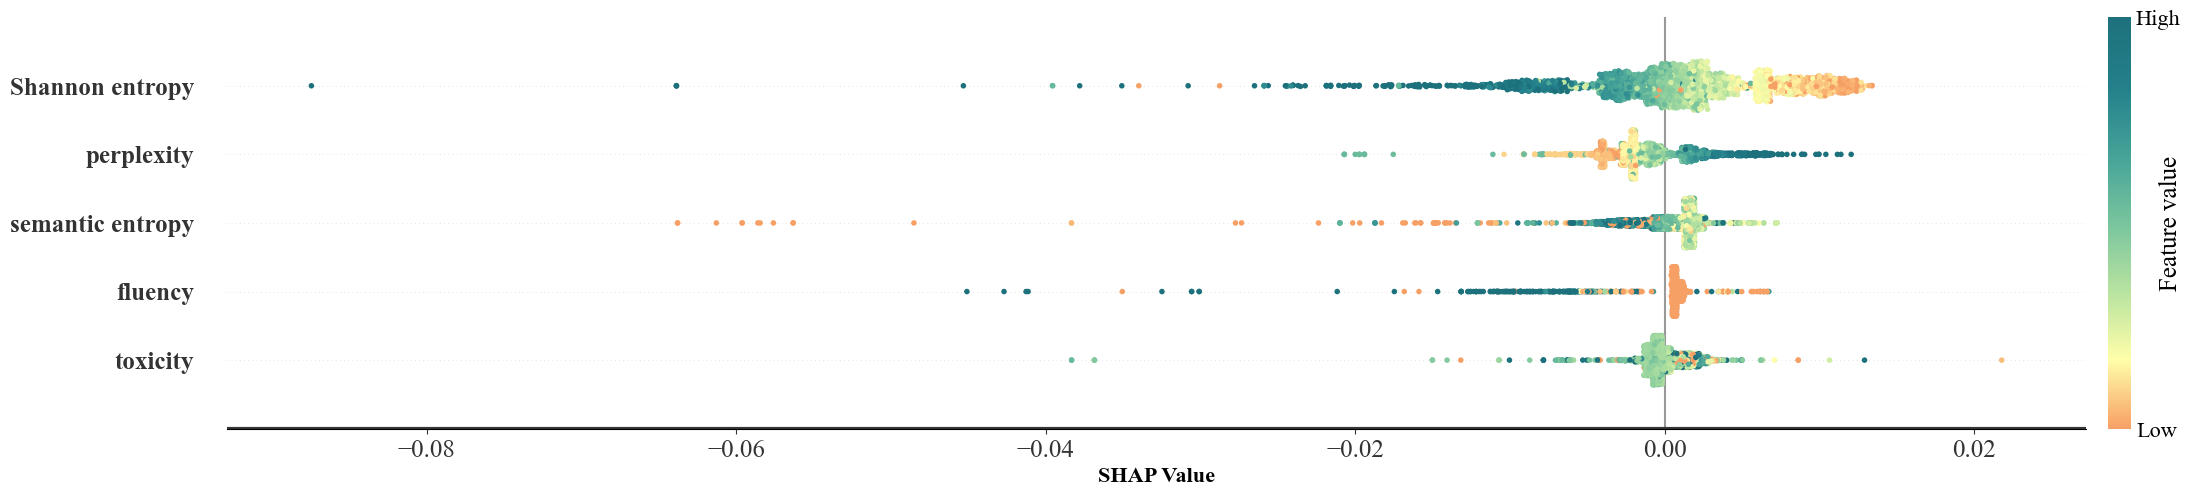

In [3]:
# 选择特征
cols = ['fluency', 'toxicity', 'Shannon entropy','perplexity', 'semantic entropy']

# 训练xgboost回归模型
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model.fit(data[cols], data['semantic similarity'].values)

# 引用package并且获得解释器explainer
explainer = shap.Explainer(model)
# 获取训练集data各个样本各个特征的SHAP值
shap_values = explainer(data[cols])

# 可以确认基线值就是训练集的目标变量的拟合值的均值。
y_base = explainer.expected_value
# print(y_base)
data['pred'] = model.predict(data[cols])
# print(data['pred'].mean())

# summary_plot++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###shap.summary_plot源码修改：
#     # draw the color bar
#     if color_bar and features is not None and plot_type != "bar" and \
#             (plot_type != "layered_violin" or color in pl.cm.datad):
#         import matplotlib.cm as cm
#         m = cm.ScalarMappable(cmap=cmap if plot_type != "layered_violin" else pl.get_cmap(color))
#         m.set_array([0, 1])
#         # cb = pl.collections[0].colorbar(m, ax=pl.gca(), ticks=[0, 1],pad=0.01)
#         cb = pl.colorbar(m, ax=pl.gca(), pad=0.01, aspect=18)
#         # cb.ax.set_position([0.755, 0.11, 0.02, 0.77])
#         # cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
#         # cb.set_label(color_bar_label, size=28, labelpad=0)
#         ######
#         cb.set_ticks([0, 1])
#         cb.set_ticklabels(['Low', 'High'])
#         cb.set_label("Feature value", labelpad=-16, size=18)
#         #######
#         cb.ax.tick_params(labelsize=15, length=0)
#         cb.set_alpha(1)
#         cb.outline.set_visible(False)
# #         bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
# #         cb.ax.set_aspect((bbox.height - 0.9) * 20)
#         # cb.draw_all()
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

clist = ["#F7A065", "#fffea9", "#b7e3a0", "#78c49d", "#44a298","#237f8b","#1D717C"]
newcmp = LinearSegmentedColormap.from_list('chaos', clist)

# 生成 SHAP summary_plot
plt.figure()
plt.rcParams.update({'font.family': 'Times New Roman'})
shap.summary_plot(shap_values, 
                  show=False, 
                  cmap=newcmp, 
                  use_log_scale=False, 
                  sort=True, 
                  alpha=1, 
                  plot_size=(24, 8*0.618),
                  color_bar=True
                  )

# 修改 x 轴和 y 轴刻度标签的字体大小
plt.xticks(fontsize=18, fontweight='medium', fontfamily='Times New Roman')  # 设置 x 轴刻度字体大小、粗细和字体
plt.yticks(fontsize=18, fontweight='semibold', fontfamily='Times New Roman')  # 设置 y 轴刻度字体大小、粗细和字体


# 修改x轴标签
plt.xlabel('SHAP Value', fontsize=16, fontdict={'weight': 'bold'})  # 修改x轴标签的内容和字体大小

# 获取当前轴对象
ax = plt.gca()
ax.axhline(y=-1, color='#363636', linewidth=3)

# 保存图片到本地，设置 dpi 为 300
plt.savefig('./plot_2_300dpi.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('./plot_2_300dpi.png', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_2_300dpi.tiff', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_2_300dpi.svg', bbox_inches='tight', dpi=300)

# 显示图像
plt.show()

### 图3

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import shap

#### 3.1力图

In [8]:
cols = [2, 3, 4, 5, 6, 7]
cols_name = ['semantic similarity', 'fluency', 'toxicity', 'Shannon entropy', 'perplexity','semantic entropy']
df = pd.read_excel("jfleg_data_all.xlsx", usecols=cols)

# 提取 'semantic_similarity' 列
semantic_similarity = df[['semantic similarity']]

# 对其他列进行标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns=['semantic similarity']))
df_scaled = pd.DataFrame(scaled_data, columns=df.columns[:-1])  # 除去 'semantic_similarity' 后的列名

# 将 'semantic_similarity' 列合并回去
df_scaled = pd.concat([semantic_similarity.reset_index(drop=True), df_scaled], axis=1)

# 选择所需列
df = df_scaled[cols_name]
df.head()


,semantic similarity,fluency,toxicity,Shannon entropy,perplexity,semantic entropy
0,0.901009,0.598343,0.016714,0.723976,0.373239,0.665820
1,0.992025,0.342702,0.014098,0.758437,0.506295,0.510259
2,0.963557,0.348808,0.016663,0.858522,0.671426,0.705733
3,0.994655,0.346681,0.016714,0.773507,0.585065,0.539826
4,0.991845,0.346681,0.016714,0.778501,0.480598,0.548796


In [9]:
# 选择特征
cols = ['fluency', 'toxicity', 'Shannon entropy', 'perplexity','semantic entropy']
# 训练xgboost回归模型
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model.fit(df[cols], df['semantic similarity'].values)
# 引用package并且获得解释器explainer
explainer = shap.Explainer(model)
# 获取训练集data各个样本各个特征的SHAP值
shap_values = explainer(df[cols])
# print(shap_values.shape)
# print(df[cols])
# 可以确认基线值就是训练集的目标变量的拟合值的均值。
y_base = explainer.expected_value
# print(y_base)
df['pred'] = model.predict(df[cols])
# print(data['pred'].mean())

# 绘制 SHAP 力图时保留三位小数
shap_values.values = np.round(shap_values.values, 4)
shap_values.base_values = np.round(shap_values.base_values, 4)
shap_values.data = np.round(shap_values.data, 4)

# 色系一
clist = ["#45978B","#E08648"]
# 色系二
# clist = ['#2166ac', '#d6604d']
# 色系三
# clist = ['#66bd63', '#f46d43']
# force_plot++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
shap.initjs()

# 随机选择 100 个样本的索引
random_indices = np.random.choice(len(shap_values), size=len(shap_values), replace=False)
# 提取对应样本的 SHAP 值并计算平均值
mean_shap_values = shap_values[random_indices].mean(axis=0)

shap.plots.force(mean_shap_values, matplotlib=False, show=False, plot_cmap=clist)\
        # .savefig('./force_1.bmp', bbox_inches='tight', dpi=300)

[16:11:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


#### 3.2 热力图

In [10]:
cols = [2, 3, 4, 5, 6, 7]
cols_name = ['semantic similarity', 'Shannon entropy', 'perplexity', 'semantic entropy', 'fluency', 'toxicity']
df = pd.read_excel("jfleg_data_all.xlsx", usecols=cols) 

# 使用 StandardScaler 对数据进行标准化
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data, columns=df.columns)

df = df[cols_name]
df.head()

,semantic similarity,Shannon entropy,perplexity,semantic entropy,fluency,toxicity
0,0.557452,0.723976,0.373239,0.665820,0.598343,0.016714
1,0.964344,0.758437,0.506295,0.510259,0.342702,0.014098
2,0.837081,0.858522,0.671426,0.705733,0.348808,0.016663
3,0.976102,0.773507,0.585065,0.539826,0.346681,0.016714
4,0.963542,0.778501,0.480598,0.548796,0.346681,0.016714


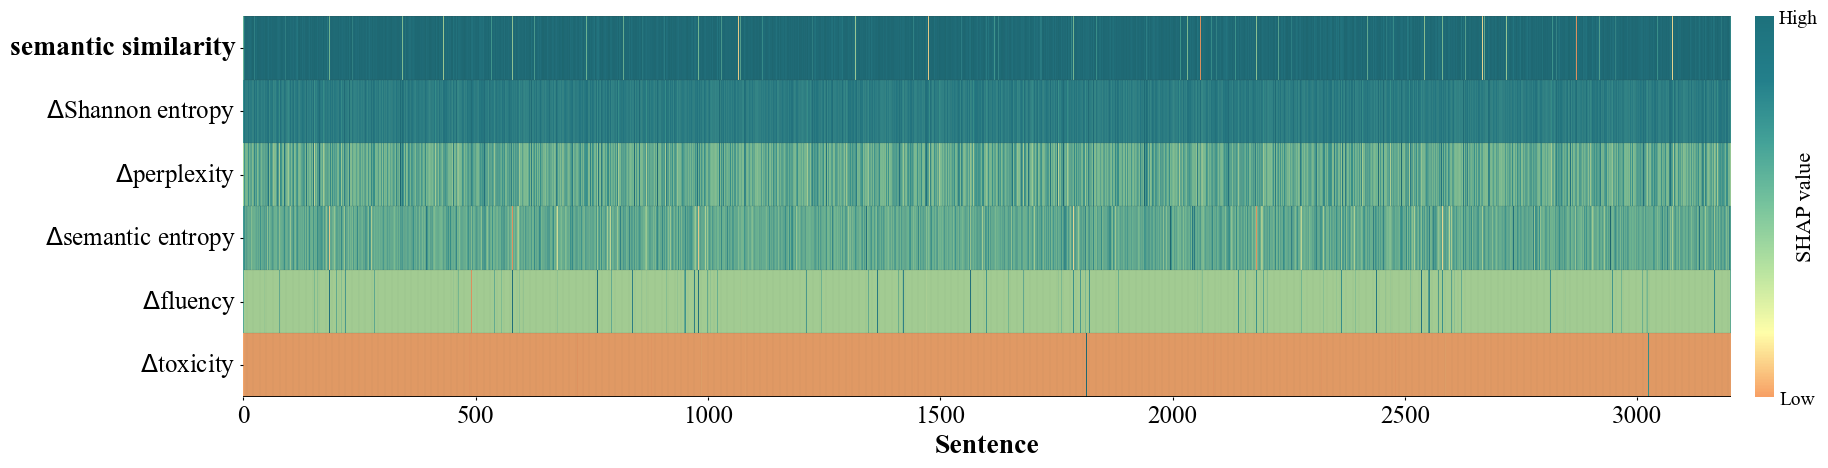

In [11]:
# 请确保df包含了'ppl'列数据
all_data = df.values.T
# ppl_data = df['fluency'].values.reshape(1, 1601)

## 色系一
clist = ["#F7A065", "#fffea9", "#b7e3a0", "#78c49d", "#44a298","#237f8b","#1D717C"]
## 色系二 RdBu颜色列表
# clist = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']  # RdBu颜色列表
## 色系三
# RdYlGn_r

newcmp = LinearSegmentedColormap.from_list('chaos', clist)

plt.figure(figsize=(24, 8*0.618))
plt.rcParams.update({'font.family': 'Times New Roman'})
ax_heatmap = sns.heatmap(all_data, 
                         cmap=newcmp, 
                         linewidths=0, 
                         linecolor='gray'
                         )  # 颜色条的大小)

# # 设置色条的位置
cbar = ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.755, 0.11, 0.02, 0.77])  # 根据需要调整数值以确定位置

vmin = all_data.min()
vmax = all_data.max()

cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low', 'High'], size=14)  # 根据需要调整标签
cbar.ax.tick_params(size=0)
cbar.set_label("SHAP value", labelpad=-16, size=16)

# 设置纵坐标 y轴 刻度标签
yticklabels = df.columns
yticklabels = [r'$\Delta$' + label for label in yticklabels]
yticklabels[0] = df.columns[0]
# yticklabels = [label for label in yticklabels]
ax_heatmap.set_yticklabels(yticklabels, rotation=0, size=18, fontweight='normal')
# 获取第一个标签的文本对象
label_text = ax_heatmap.get_yticklabels()[0]
# 设置第一个标签的字体样式为粗体
label_text.set_weight('bold')
label_text.set_fontsize(20)

# 设置横坐标 x轴 的刻度位置
ax_heatmap.set_xticks(np.arange(0, all_data.shape[1], 500))
ax_heatmap.set_xticklabels(['0', '500', '1000', '1500', '2000', '2500', '3000'], rotation=0, size=18)

# 绘制横坐标x轴的黑色坐标轴线
ax_heatmap.axhline(y=all_data.shape[0], color='black', linewidth=2)
ax_heatmap.axhline(y=0, color='#363636', linewidth=0.18)

ax_heatmap.set_xlabel('Sentence', size=20, fontdict={'weight': 'bold'})

# 加格子外框
def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x, y), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect
for i in range(1, all_data.shape[1]):
    for j in range(0, all_data.shape[0]+1):
        highlight_cell(i, j, color="#363636", linewidth=0.03)

# 刻度点
ax_heatmap.tick_params(axis="x", bottom=True, length=2)
ax_heatmap.tick_params(axis="y", left=True, length=2)

plt.savefig('./plot_3_300dpi.jpg', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_3_300dpi.png', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_3_300dpi.tiff', bbox_inches='tight', dpi=300)
# plt.savefig('./plot_3_300dpi.svg', bbox_inches='tight', dpi=300)

plt.show()